# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

plt.style.use("seaborn-whitegrid")

# Loading data

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Missing Values

#### Missing Training Data

In [3]:
miss_train = df_train.isnull().sum()
percent_train = (df_train.isnull().sum()/df_train.isnull().count())*100
missing_train = pd.concat([miss_train, percent_train], axis = 1, keys = ["Total Missing", "Percent Missing"]).sort_values(by = "Total Missing", ascending = False)
missing_train.head()

,Total Missing,Percent Missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000


It is clear that more that 77% and 78% of "Cabin" data is missing from both training and test data. Therefore, "Cabin" feature must be removed as we cannot rely on such bad quality data.

In [4]:
df_train = df_train.drop(["Cabin"], axis = 1)

For the "Age", about 20% is missing from both the training and test data. While it seems quite a lot of missing data, we can't trust the decision to remove this feature as the common sense tells that it can be correlated to the survival rate.

A correlation heatmap will cut it short and detect the values that are most correlated to survival rate.

<AxesSubplot:>

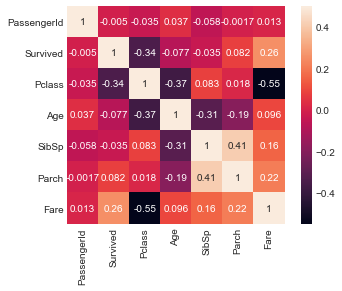

In [5]:
corr_mat = df_train.corr()
sns.heatmap(corr_mat, vmax = 0.5, annot = True, square = True)

Unfortunately, the heatmap did not indicate a clear strong correlation between variables. However, we will still keep the "Age" feature but we have to decide what to do with their missing values. I decided to further investigate how "Age" is associated with categorical variables....

<AxesSubplot:xlabel='Sex', ylabel='Age'>

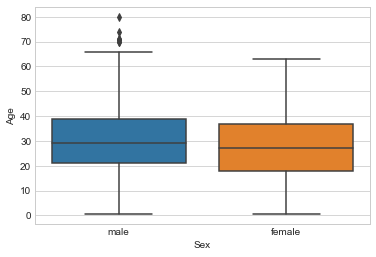

In [6]:
sns.boxplot(x = df_train["Sex"], y = df_train["Age"])

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

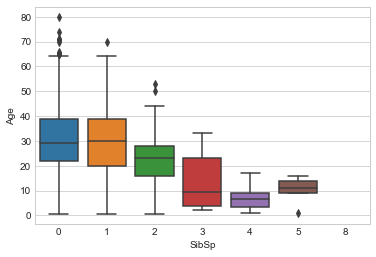

In [7]:
sns.boxplot(x = df_train["SibSp"], y = df_train["Age"])

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

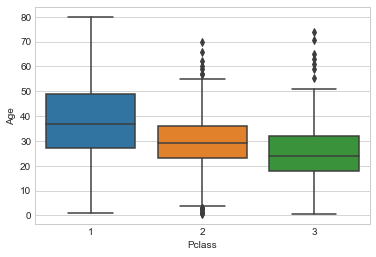

In [8]:
sns.boxplot(x = df_train["Pclass"], y = df_train["Age"])

<AxesSubplot:xlabel='Embarked', ylabel='Age'>

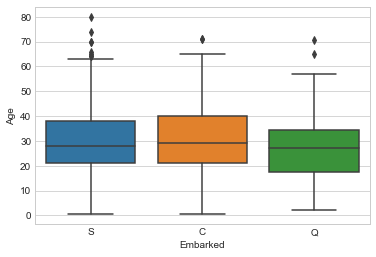

In [9]:
sns.boxplot(x = df_train["Embarked"], y = df_train["Age"])

I can see that "Age" is changing along the "SibSP" values. I suggest that we group the "Age" into groups according to "SibSP" and "Pclass" values. Then we can fill the missing "Age" values with the median of each group.

In [10]:
df_train.groupby(["SibSp","Pclass"])[["Age"]].median()

Age
SibSp Pclass      
0     1       37.0
      2       30.0
      3       26.0
1     1       38.0
      2       29.0
      3       25.0
2     1       44.0
      2       23.5
      3       19.5
3     1       23.0
      2       30.0
      3        6.0
4     3        6.5
5     3       11.0
8     3        NaN

In [11]:
df_train["Age"] = df_train.groupby(["SibSp","Pclass"])["Age"].apply(lambda x:x.fillna(x.median()))
df_train["Age"] = df_train["Age"].apply(np.ceil)

Now we can check the status of "Age" missing values:

In [12]:
df_train["Age"].isnull().sum()

7

There is still 7 missing values, we should investigate where these came from...

In [13]:
df_train[["Age", "SibSp", "Pclass"]].sort_values(by= "Age")

,Age,SibSp,Pclass
164,1.0,4,3
831,1.0,1,2
172,1.0,1,3
827,1.0,0,2
386,1.0,5,3
...,...,...,...
201,NaN,8,3
324,NaN,8,3
792,NaN,8,3
846,NaN,8,3


So because the category of "SibSp" = 8 has all its data missing. We can do it instead by grouping only using the "Pclass".

In [14]:
df_train["Age"] = df_train.groupby(["Pclass"])["Age"].apply(lambda x:x.fillna(x.median()))
df_train["Age"] = df_train["Age"].apply(np.ceil)
df_train["Age"].isnull().sum()

0

"Embarked" has two missing values as well. We can fill it with the mode as being a categorical variable.

In [15]:
df_train["Embarked"] = df_train["Embarked"].fillna("S")
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Now we have no missing values in our training dataset! Let's move into the test data:

#### Missing Test Data

In [16]:
miss_test = df_test.isnull().sum()
percent_test = (df_test.isnull().sum()/df_test.isnull().count())*100
missing_test = pd.concat([miss_test, percent_test], axis = 1, keys = ["Total Missing", "Percent Missing"]).sort_values(by = "Total Missing", ascending = False)
missing_test.head()

,Total Missing,Percent Missing
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
PassengerId,0,0.000000
Pclass,0,0.000000


Remove "Cabin" feature

In [17]:
df_test = df_test.drop(["Cabin"], axis = 1)

As we have almost the same percentage of "Age" missing values, I am planning to use the same as I did in the training data, but it's always better to check first...

In [18]:
df_test["Age"] = df_test.groupby(["SibSp","Pclass"])["Age"].apply(lambda x:x.fillna(x.median()))
df_test["Age"] = df_test["Age"].apply(np.ceil)
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

Now, we have only 1 missing value from the "Fare" feature. I will comfortably fill it with the median value.

In [19]:
df_test["Fare"] = df_test["Fare"].fillna(df_test["Fare"].median())
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

I feel glad when I reach the moment that I have my dataset having no missing values any more! However, the rest of analysis can still bring things upside down.

# Feature Engineering

In order to decide about our features that we are going to finally use in prediction, I would like to see the heatmap again but with three differences from the one I previously viewed:

    1. This one will be plotted using the entire dataset(training + test)
    2. Remember that this one include our filled data!
    3. As this includes test data, "Survived" is missing from the test part and we should remove it from the heatmap
    4. Remember that we need this heatmap to see the correlation between features

In [20]:
df_data = pd.concat([df_train, df_test])
df_data = df_data.set_index("PassengerId", drop = True)
df_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


<AxesSubplot:>

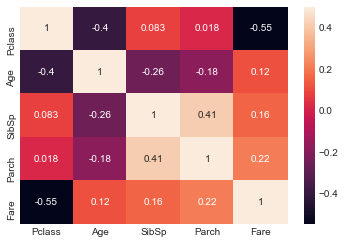

In [21]:
corr_mat_2 = df_train.iloc[:,2:].corr()
sns.heatmap(corr_mat_2, vmax = 0.5, annot = True)

Some takeaways from the heatmap:

    1. Parch and SibSp are correlated. Although the correlation is not that high, they deserve further investigation as number of siblings and parents might be somehow combined in one feature
    
    2. The same in Pclass and Fare, my understanding is that Pclass can affect the survival rate, fare is absolutely inversely correlated to Pclass. So we need to think about it.

##### Pclass and Fare

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

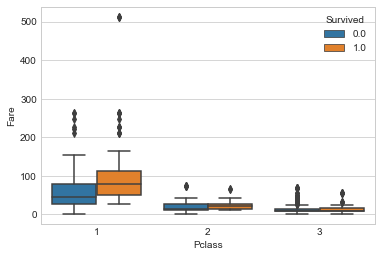

In [22]:
sns.boxplot(x = "Pclass", y = "Fare", hue = "Survived",data = df_data)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

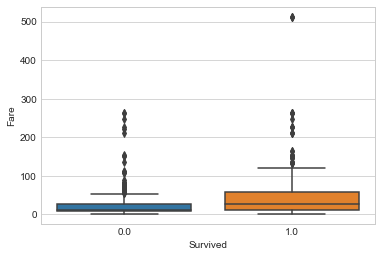

In [23]:
sns.boxplot(y = "Fare", x = "Survived", data = df_data)

<AxesSubplot:xlabel='Survived', ylabel='count'>

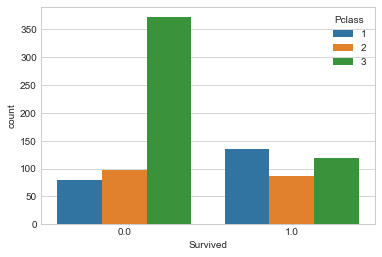

In [24]:
sns.countplot(x = "Survived", hue = "Pclass", data = df_data)

So what we got from these plots?

    1. Most of the 3rd class people did not survive regardless of the fare they paid
    2. For first class people, more than 50% of them survived, the median fare for those who survived is a bit higer than those who did not survive in the first class
    3. The second class survival rate seems not affected by neither fare nor being in the second class

What we can conclude from this? Pclass is more meaningfull parameter. Although having higher median fare for those who survived in the first class, the difference is minor. I will go for removing "Fare" feature as it is more misleading than being helpful in our prediction.

#### Parch and SibSp

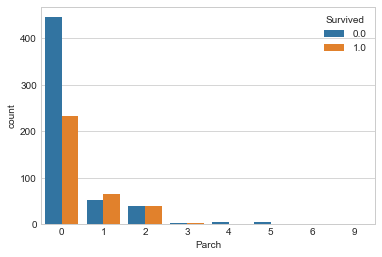

In [25]:
sns.countplot(x ="Parch",hue = "Survived", data = df_data)
plt.legend(title = "Survived",loc = "upper right")

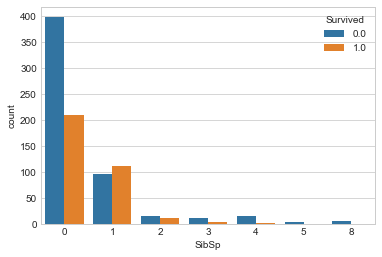

In [26]:
sns.countplot(x =df_data["SibSp"],hue = df_data["Survived"] )
plt.legend(title = "Survived",loc = "upper right")

I can tell from these graphs that the more family members you have, the more your survival rate is. However, this is only up to limit, when you have many family members, the probability of survival decreases.

I propose adding another feature named "Family Size" and then we can remove both "SibSp" and "Parch". I will create it first and make sure things are on the right track.

<AxesSubplot:xlabel='Family Size', ylabel='count'>

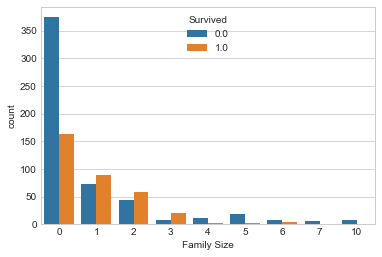

In [27]:
df_data["Family Size"] = df_data["Parch"] + df_data["SibSp"]
sns.countplot(x = "Family Size", hue = "Survived", data = df_data)

now I am completely comfortable with this parameter. we can see that being alone makes the probability of survival less than 50%

In [28]:
df_data = df_data.drop(["SibSp", "Parch"], axis = 1)

Then, I don't think anybody believes that "Name" can affect survival rate by any means....

In [29]:
df_data = df_data.drop(["Name"], axis = 1)

Let's discuss "Ticket"

In [30]:
# df_data["Ticket"].unique()

It seems like they are only ticket numbers which we cannot infer the seat location from it. So, it is going to be removed.

In [31]:
df_data = df_data.drop(["Ticket"], axis = 1)

In [32]:
df_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family Size
PassengerId,,,,,,,
1,0.0,3,male,22.0,7.2500,S,1
2,1.0,1,female,38.0,71.2833,C,1
3,1.0,3,female,26.0,7.9250,S,0
4,1.0,1,female,35.0,53.1000,S,1
5,0.0,3,male,35.0,8.0500,S,0


Now we can convert categorical data....

In [37]:
df_data = pd.get_dummies(df_data)

Let's split the data again into training and test data:

In [38]:
X_train = df_data.iloc[:len(df_train),1:]
Y_train = df_data.loc[:len(df_train),['Survived']]
X_test = df_data.iloc[len(df_train):,1:]

In [44]:
X_test.shape

(418, 9)

# Model Selection by Cross Validation

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Text(0, 0.5, 'Model Accuracy')

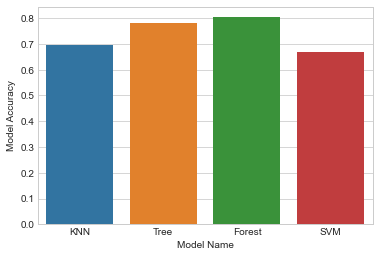

In [40]:
KNN_model = KNeighborsClassifier()
Tree_model = DecisionTreeClassifier()
Forest_model = RandomForestClassifier()
SVM_model = SVC()

KNN_score = cross_val_score(KNN_model, X_train,Y_train,cv = 5)
Tree_score = cross_val_score(Tree_model, X_train,Y_train,cv = 5)
Forest_score = cross_val_score(Forest_model, X_train,Y_train,cv = 5)
SVM_score = cross_val_score(SVM_model, X_train,Y_train,cv = 5)


p =sns.barplot(x = ["KNN", "Tree", "Forest", "SVM"], y = [KNN_score.mean(), Tree_score.mean(), Forest_score.mean(), SVM_score.mean()])
p.set_xlabel("Model Name")
p.set_ylabel("Model Accuracy")

It seems like the Random Forest model had the best score. However, we still need to tweak the hyper parameters to reach the best model efficiency.

# Model Hyperparameters Tuning

In [53]:
parameters = {"criterion": ["gini", "entropy"], "max_depth": [1,2,3,4,5,6,7,8,9,10,11]}
forest_optimized = GridSearchCV(Forest_model, param_grid = parameters, cv = 5)
forest_optimized.fit(X_train, Y_train)
forest_optimized.best_score_
predictions = forest_optimized.best_estimator_.predict(X_test).astype(int)
gender_submission = pd.DataFrame({'PassengerId': df_test.PassengerId, "Survived": predictions})


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

# Predictions

In [59]:
gender_submission.to_csv(r"C:\Users\hp\Desktop\projet\Titanic-Survival-Prediction\gender_submission.csv", index = False)

In [60]:
gender_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
